<h1 style="color:white;background:black;text-align:center;padding:1rem 0">Customer Segmentation / Clustering </h1>

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv("Transactions.csv")

<h2 style="color:white;background:black;text-align:center;padding:1rem 0"> Aggregate the data </h2>

In [3]:
customer_transaction = transactions.groupby('CustomerID').agg(
    total_transactions = ("TransactionID" , 'count'),
    total_quantity = ('Quantity' , 'sum'),
    total_revenue= ('TotalValue' , 'sum'),
    avg_transaction_value = ("TotalValue" , 'mean'),
    product_variance = ("ProductID" , 'nunique')
).reset_index()

<h2 style="color:white;background:black;text-align:center;padding:1rem 0">Merge Aggregated Data With Customer Data</h2>

In [4]:
data = pd.merge(customers , customer_transaction , on="CustomerID" , how='inner' )

In [5]:
data.head()

,CustomerID,CustomerName,Region,SignupDate,total_transactions,total_quantity,total_revenue,avg_transaction_value,product_variance
0,C0001,Lawrence Carroll,South America,2022-07-10,5,12,3354.52,670.904,5
1,C0002,Elizabeth Lutz,Asia,2022-02-13,4,10,1862.74,465.685,4
2,C0003,Michael Rivera,South America,2024-03-07,4,14,2725.38,681.345,4
3,C0004,Kathleen Rodriguez,South America,2022-10-09,8,23,5354.88,669.360,8
4,C0005,Laura Weber,Asia,2022-08-15,3,7,2034.24,678.080,3


<h2 style="color:white;background:black;text-align:center;padding:1rem 0">Feature Engineering</h2>
<h2>Encode Categorical Data (one hot encoding)</h2>

In [6]:
encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(data[['Region']]).toarray()
encoded_region_df = pd.DataFrame(encoded_region , columns=encoder.get_feature_names_out(['Region']))

In [7]:
encoded_region_df

,Region_Asia,Region_Europe,Region_North America,Region_South America
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
194,0.0,1.0,0.0,0.0
195,0.0,1.0,0.0,0.0
196,0.0,1.0,0.0,0.0
197,0.0,1.0,0.0,0.0


### Concatenate Encoded Data

In [8]:
data = pd.concat([data , encoded_region_df] , axis=1)
data.drop(['CustomerID' , 'CustomerName' , 'Region' , 'SignupDate'] , axis=1 , inplace=True)

### Scale the Numeical Data

In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

<h2 style="color:white;background:black;text-align:center;padding:1rem 0">Clustering</h2>

<h2>Determine Optimal Number of Clusters</h2>

In [20]:
cluster_range = range(2, 11)
db_scores = []
wcss = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    db_scores.append(davies_bouldin_score(scaled_data, clusters))
    wcss.append(kmeans.inertia_)
    
optimal_clusters = cluster_range[np.argmin(db_scores)]

### Perform K-Means Clustering

In [13]:
kmeans = KMeans(n_clusters=optimal_clusters ,random_state = 42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

In [21]:
db_scores # shape was not matching error occurred so i used to get the shape other wise step is not important 

[1.6000249246331681,
 1.8081085398807495,
 1.2736001034340774,
 1.0087180296821647,
 1.0354473903212857,
 1.1774426921640875,
 1.102530994961898,
 0.9457699587105142,
 0.978811394319167]

<h2 style="color:white;background:black;text-align:center;padding:1rem 0">Visualization</h2>
<br>
<h2>Plot DB index and WCSS</h2>

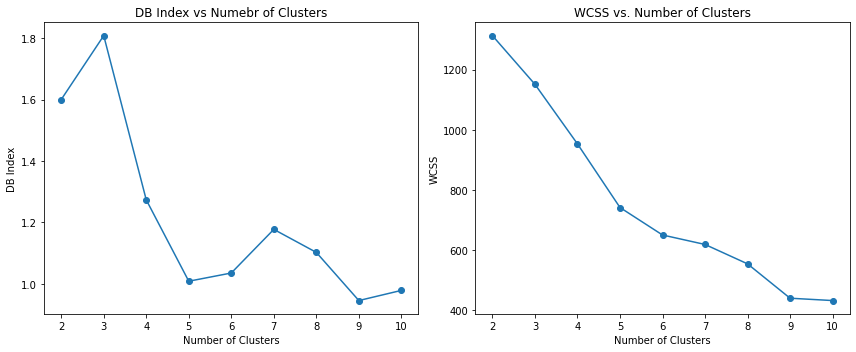

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(cluster_range , db_scores , marker='o')
plt.title("DB Index vs Numebr of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")

plt.subplot(1, 2, 2)
plt.plot(cluster_range, wcss, marker='o')
plt.title('WCSS vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.tight_layout()
plt.show()

### PCA for Visualization

In [16]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

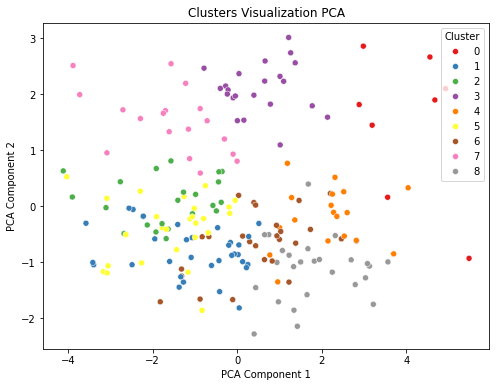

In [17]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_data[:,0] , y=pca_data[:,1] , hue=data['Cluster'] , palette='Set1')
plt.title("Clusters Visualization PCA")
plt.xlabel('PCA Component 1')
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()